<img src="images/ublogo.png"/>

### CSE610 - Bayesian Non-parametric Machine Learning

  - Lecture Notes
  - Instructor - Varun Chandola
  - Term - Fall 2020

### Objective
The objective of this notebook is to discuss non-parametric Bayesian methods for clustering.

<div class="alert alert-info">

**Note:** This material is loosely based on Chapter 2 of the lecture notes by [Orbanz](http://www.gatsby.ucl.ac.uk/~porbanz/papers/porbanz_BNP_draft.pdf).

</div>

Consider the problem of clustering where we are given $N$ instances, ${\bf x}_1,{\bf x}_2,\ldots,{\bf x}_N$ and the goal is partition this set into subsets, also referred to as **clusters**. The objective is to determine the partitions, such that instances belonging to the same cluster should be similar.

Consider the following example in which each observation is in $\mathbb{R}^2$ and $N = 1000$.

In [24]:
import scipy.stats as st

In [33]:
np.arange(len(alpha))

array([0, 1, 2, 3])

<BarContainer object of 4 artists>

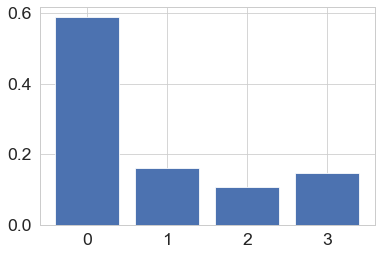

In [50]:
alpha = np.array([1,1,1,1])
plt.bar(np.arange(len(alpha)),st.dirichlet(alpha).rvs(1).flatten())

In [5]:
%run Utilities.ipynb

 /Users/chandola/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:The sklearn.datasets.openml module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.


In [9]:
from sklearn.datasets import make_blobs

X,y = make_blobs(n_samples=1000, n_features=2,centers=3)

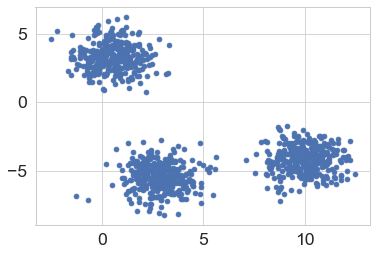

In [10]:
plt.scatter(X[:,0],X[:,1])

### From hard clustering to soft clustering

In the above data set, it is evident this data can be partitioned into three groups and the objective of a clustering method would be to assign to each observation a cluster label 1, 2 or 3. Such an assignment defines a partition of the index set {1, . . . , 1000} into three disjoint sets.

There are several clustering algorithms that can achieve the above objective, e.g., k-means.

However, the basic assumption for these methods is that every data instance belongs exactly to one cluster.

In probabilistic clustering, the clustering assignment, $z_i$ is treated as an unobserved random variable, where $z_i = k$ means that the data instance ${\bf x}_i$ belongs to cluster $k$.

We assume that $p_k()$ is the probability distribution of a cluster, indexed by $k$. Let $\pi_k$ denote the probability of a data instance to belong to cluster $k$. Obviously, 
$$
\sum_k \pi_k = 1
$$
Then the probability density of any instance, ${\bf x}$ can be written as:
$$
p({\bf x}) = \sum_{k=1}^K \pi_k p_k({\bf x})
$$
We will assume that each cluster-specific distribution, $p_k()$ is parameterized by a set of parameters, denoted by $\theta_k$.
#### Bayesian finite vs. infinite mixtures

In the above expression, we assume that $k$ ranges from 1 to $K$ where $K$ is finite. This is a **finite mixture model**. However, later we will consider cases where $K$ can go to $\infty$, also referred to as an **infinite mixture model**.

The generative process for a FMM is as follows:
\begin{eqnarray}
\boldsymbol{\pi}\vert\alpha & \sim & \text{Dir}(\alpha/K,\ldots,\alpha/K)\\
z_i\vert \boldsymbol{\pi} & \sim & \text{Multi}(\boldsymbol{\pi})\\
\theta_k\vert \lambda & \sim & G_0(\lambda)\\
x_i\vert z_i, \{\theta_k\}_{k=1}^K & \sim & F(\theta_{z_i})
\end{eqnarray}

Each observation $x_i$ is generated by first sampling a cluster index, $z_i$ from a Multinomial distribution, parameterized by a $K$ length vector, $\boldsymbol{\pi}$. A symmetric Dirichlet prior is used to generate ${\bf \pi}$. The actual value is sampled from a cluster specific distribution, $F$, parameterized by $\theta_k$. The cluster specific distribution parameters are also generated from a prior (or base) distribution, $G_0$, parameterized by $\lambda$.

> What is a **Dirichlet distribution**?

If one lets $K$ go to $\infty$, FMM becomes a DPMM. However, in the case of DPMM, one can no longer use the multinomial distribution with a Dirichlet distribution prior to generate cluster assignments. This is because we do not fix the number of clusters in DPMM. So instead of sampling ${\bf \pi}$ from a Dirichlet distribution, we can use the stick breaking model to give us ${\bf \pi}$ (of arbitrary length) and then follow the same strategy as the FMM.

The generative process can be written as:
\begin{eqnarray}
{\bf \pi}\vert\alpha & \sim & \text{StickBreaking}(\alpha)\\
z_i\vert {\bf \pi} & \sim & \text{Multi}({\bf \pi})\\
\theta_k\vert \lambda & \sim & G_0(\lambda)\\
x_i\vert z_i, \{\theta_k\}_{k=1}^K & \sim & F(\theta_{z_i})
\end{eqnarray}


The `StickBreaking` procedure above is a way to generalize the fixed length $\boldsymbol{\pi}$ to a possibly infinite length $\boldsymbol{\pi}$. We will actually look at three different ways to sample an arbitrary length $\boldsymbol{\pi}$.

### Chinese restaurant process (CRP)
This analogy is often used to assigning observations to groups. Consider a restaurant in which the customers are arranged in the following way:

* Initially the restaurant is empty
* First customer selects an empty table (group) and sits down. The customer selects the food (parameters for data generated by that group) for that table. Any subsequent members of the table will be constrained to eat that food. 
* Second customer can either sit at an empty table with a probability $\frac{\alpha}{1+\alpha}$ (and order food, i.e., select parameters) or will sit with the previous customer with probability $\frac{1}{1+\alpha}$ (and share the food).
* The $(n+1)^{th}$ customer can either sit at an empty table with probability $\frac{\alpha}{n+\alpha}$ or sit at a non-empty table number $k$ with probability $\frac{n_k}{n+\alpha}$, where $n_k$ is the number of customers already sitting at that table.

In summary, one can write that:
$$
p(\phi_n = k|\phi_{1:n-1}) = \frac{n_k}{\alpha + n - 1}
$$
If the $k^{th}$ table is already occupied with $n_k$ customers sitting, and
$$
p(\phi_n = k|\phi_{1:n-1}) = \frac{\alpha}{\alpha + n - 1}
$$
If the $k^{th}$ table is empty.

In [11]:
def createNewTable(tables,newCustomerId):
    if len(tables) == 0:
        newTableId = 0
    else:
        newTableId = max(tables.keys()) + 1
    tables[newTableId] = [newCustomerId]
    return tables

In [12]:
def crp(numCustomers,alpha):
    tables = {}
    counts = []
    for n in range(1,numCustomers+1):
        if n == 0: # first customer
            createNewTable(tables,n)
        else:
            # create a probability vector and sample from that
            probVec = []
            # first entry will be for choosing a new table
            probVec.append(alpha/(n+alpha))
            # rest of the entries will be for joining existing tables
            for t in tables.keys():
                probVec.append(len(tables[t])/(n+alpha))
            # get a random choice using the probVec vector
            c = np.where(np.random.multinomial(1, probVec, size=1)[0] == 1)[0][0]
            if c == 0:
                createNewTable(tables,n)
            else:
                tables[c-1].append(n)
        counts.append(len(tables))
    return tables,counts

<BarContainer object of 7 artists>

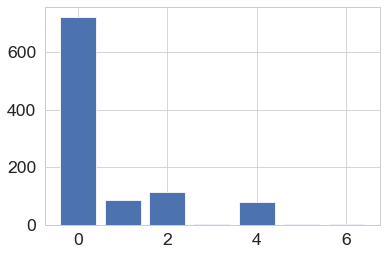

In [13]:
tables,counts = crp(1000,1)
tCounts = []
for t in tables.keys():
    tCounts.append(len(tables[t]))
plt.bar(range(len(tCounts)),tCounts)

#### Effect of $\alpha$ on number of tables created

In [14]:
tableCounts = []
for alpha in range(1000):
    tables,counts = crp(100,alpha)
    tableCounts.append(len(tables))

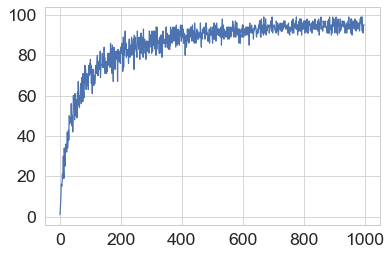

In [15]:
plt.plot(range(1000),tableCounts)

Clearly the number of tables (clusters) increases with increasing $\alpha$, which can be thought of as a _concentration parameter_. Higher value indicates more likelihood of creating new tables.

#### Impact of number of customers on the number of tables created

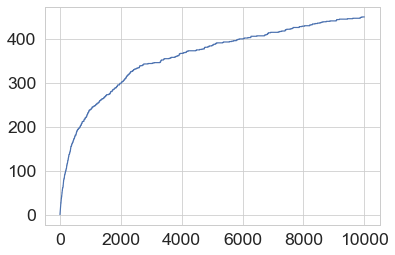

In [16]:
tables,counts = crp(10000,100)
plt.plot(counts)

The CRP model shows us how the observations are assigned to the clusters, but it does not talk about how each observation is generated, given the cluster. In our food analogy, it does not reveal what food was ordered.

### The Polya Urn Model
A similar model uses a different metaphor for infinite clusters. Starting with an empty urn and a base distribution $G_0$, the model adds a new ball with probability $\frac{\alpha}{\alpha + n}$ ($n$ is the number of balls currently in the urn), otherwise, it randomly picks a ball from the urn and adds another ball in the urn of the same color.

The polya-urn model is flexible in terms of the base distribution, $G_0$. If $G_0$ is categorical with finite number of possibilities, then the output is a sample from a Dirichlet distribution with concentration parameter $\alpha$. Here we will consider a continuous distribution.

The probability of observing a ball, given a past sequence of $n-1$ balls, can be written as:
$$
\phi_n\vert\phi_{1:n-1}  \sim \frac{\alpha G_0}{\alpha + n - 1} + \frac{\sum_{j=1}^{n-1}\delta(\phi_n - \phi_j)}{\alpha + n - 1}
$$
where the quantity $\delta(x) = 1$, if $x = 0$, and $\delta(x) = 0$, otherwise.

The above result can be easily computed by considering the fact that the $n^{th}$ ball can either be a new draw from $G_0$ with probability $\frac{\alpha}{\alpha + n - 1}$ or can be sampled uniformly from the current $n-1$ balls with a probability $1 - \frac{\alpha}{\alpha + n - 1}$. The quantity $\sum_{j=1}^{n-1}\delta(\phi_n - \phi_j)$ counts the number of balls in the urn of the same color as $\phi_n$.



In [17]:
def polyaUrn(numBalls,alpha,baseDistribution,args=[]):
    urn = []
    for n in range(numBalls):
        # determine if a new ball needs to be sampled
        p = alpha/(alpha + n)
        c = np.random.binomial(1,p,1)[0]
        if c == 1 or n == 0:
            # add a new ball to the urn
            if(baseDistribution == np.random.uniform):
                newBall = []
                newBall.append(baseDistribution(args[0],args[1],1)[0])
                newBall.append(baseDistribution(args[0],args[1],1)[0])
            else:
                newBall = baseDistribution(args[0],args[1],1)[0]
            urn.append(newBall)
        else:
            # sample existing ball and add it back and another ball to the urn
            urn.append(urn[np.random.randint(len(urn))])
    return urn

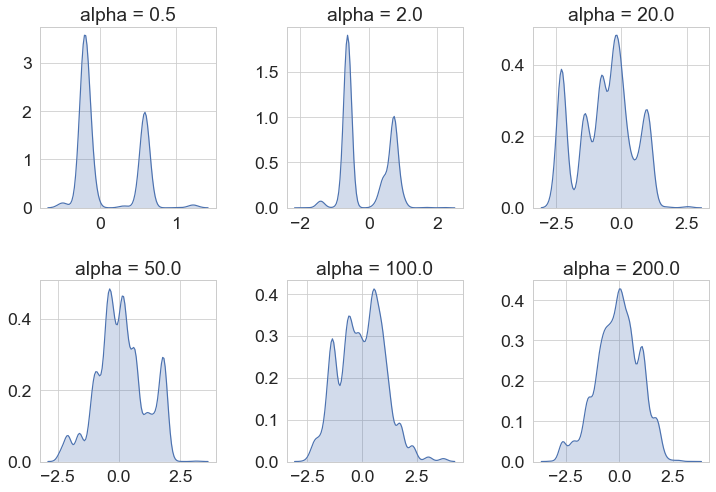

In [18]:
fig = plt.figure(figsize=[12,8])
fig.subplots_adjust(hspace=0.4, wspace=0.4)
i = 1
for alpha in (0.5,2,20,50,100,200):
    urn = polyaUrn(10000,alpha,np.random.normal,[0,1])
    ax = fig.add_subplot(2,3,i)
    sns.kdeplot(np.array(urn),shade=True)
    #ax.bar(range(len(urn)),np.array(urn))
    ax.set_title('alpha = %.1f'%alpha)
    i += 1

In [19]:
urn = polyaUrn(10000,1,np.random.normal,[0,1])
np.unique(urn)

array([-1.08831949, -1.07721294, -0.68381687, -0.68281225, -0.38187558,
       -0.02831205,  0.72361783,  0.8940417 ])

It is evident above that as the concentration parameter increases, the output of the _poly-urn model_ starts resembling the base distribution. On the other hand, lower values of $\alpha$ exhibit a clustering effect.

Similar effect can be studied in a 2-D plot

/Users/chandola/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning:

Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.



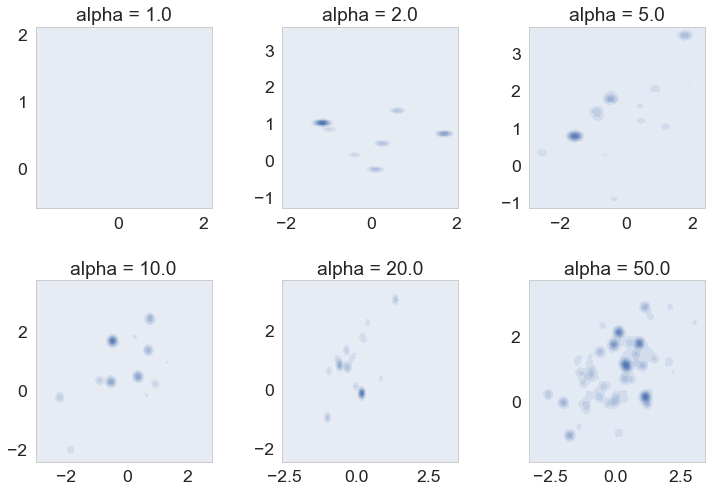

In [20]:
fig = plt.figure(figsize=[12,8])
fig.subplots_adjust(hspace=0.4, wspace=0.4)
i = 1
for alpha in (1,2,5,10,20,50):
    urn = polyaUrn(100000,alpha,np.random.multivariate_normal,[[0,1],[(1,0.5),(0.5,1)]])
    #urn = polyaUrn(1000,alpha,np.random.uniform,[0,1])
    nurn = np.array(urn)
    if alpha <= 2:
        nurn += np.random.uniform(0,0.001,nurn.shape)
    ax = fig.add_subplot(2,3,i)
    sns.kdeplot(nurn,shade=True)
    #sns.plt.scatter(nurn[:,0],nurn[:,1])
    ax.set_title('alpha = %.1f'%alpha)
    i += 1

The key observation here is that while the balls can be selected randomly from a continuous space, the model forces clustering to take place.

### Stick breaking model
For both _CRP_ and _Polya Urn_ models, once the simulation is complete, one can obtain a proportion of data points in each cluster. The _Stick Breaking_ model generates the proportions directly without running the simulation. 

Starting with a stick of unit length, the model draws a sample, $\beta_1$ for the random variable $\beta \sim Beta(1,\alpha)$. The stick is broken off at $\beta_1$. The value of $\beta_1$ is the proportion for the first cluster. The process is repeated on the remaining left portion of the stick, of length $(1 - \beta_1)$ to get proportions for subsequent clusters.

At the end, the proportions for each cluster can be used to assign points to each cluster.

While the _CRP_ and _Polya Urn_ models provide the samples from the posterior distribution $G$, the _Stick Breaking_ model directly gives the distribution.In other words, the stick breaking construction, gives us an explicit form for the posterior distribution $G$:
$$
G(\phi) = \sum_{k=1}^\infty\pi_k \delta(\phi - \phi_k),\text{ where } \phi_k \sim G_0
$$
The mixture weights, $\pi_k$, are generated according to the above described procedure:
\begin{eqnarray}
\beta_k & \sim & \text{Beta}(1,\alpha)\\
\pi_k & = & \beta_k\prod_{l=1}^{k-1}(1-\beta_l)
\end{eqnarray}
One additional result, which will be useful later, is that the sequence ${\bf \pi}$ sums upto 1, and can be used, in principle, as parameters of a Multinomial distribution.

In [21]:
def stickBreaking(numWeights,alpha):
    stickLength = 1
    weights = []
    for n in range(numWeights):
        l = np.random.beta(1,alpha)
        weights.append(l*stickLength)
        stickLength = (1 - l)*stickLength
    return weights

In [22]:
weights = stickBreaking(20,20)

<BarContainer object of 20 artists>

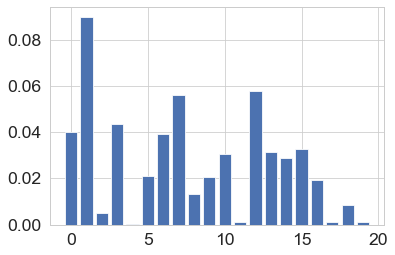

In [23]:
plt.bar(range(20),weights)

### Dirichlet Process
Going back to the Polya Urn model, we see that for a fixed $\alpha$, the simulation gives us a different distribution over the domain of the base distribution, $G_0$. Thus one can consider it as a **distribution over distributions**. This is the definition of a Dirichlet Process. 

Given a base distribution $G_0$ and a dispersion parameter $\alpha$, a Dirichlet Process is defined as a distribution, such that a sample $G \sim DP(G_0, \alpha)$ is also a distribution. $\alpha$ controls how far a random sample is away from the base distribution.

### Generative Models for Clustering
We now review how the above discussed models can be used to generate clusters and points belonging to each cluster without making any assumptions about the number of clusters.

To contrast, we will also talk about a fixed sized probabilistic clustering method - Mixture Models.

####  Mixture model based clustering
Sample mixing proportion mixture ($\pi$) from a prior Dirichlet distribution. Sample $k$ distribution parameters for each mixture component. For example, if we assume that the base distribution is Gaussian, we sample $k$ means and $k$ covariance matrices from appropriate prior distributions. For each object, $x_i$, we first sample the cluster from a categorical distribution, parameterized by $\pi$. We then sample the actual value for $x_i$ using the distribution corresponding to the cluster.

#### Chinese Restaurant Process
We first generate cluster assignments for all the points by running the CRP simulation, using $\alpha$ as the parameter for dispersion. For each cluster/group/table, distribution parameters ($\phi_n$) are sampled from a base distribution $G_0$. For each member of a given cluster, the corresponding observation ($x_i$) is sampled from $F(\phi_n)$.

#### Polya Urn Model
Generate model parameters for each point ($\phi_i$) using the Polya Urn model with base distribution $G_0$ and dispersion parameter $\alpha$. Sample $x_i$ from $F(\phi_i)$.

#### Stick Breaking Model
First generate the cluster probabilities, $w_1, w_2, \ldots, w_\infty$ using the Polya Urn model with dispersion parameter $\alpha$. Generate cluster parameters for each cluster from the base distribution $G_0$. For each data point, sample the cluster assignments from a `Multinomial distribution` using the cluster probabilities as the parameter. Given the cluster parameter for the corresponding cluster, generate $x_i$.